In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion.diffusion import Diffusion
from continous_diffusion.model import TransformerModel
from continous_diffusion.loss import Loss
from continous_diffusion.embedding import Embedder
from continous_diffusion.scheduling import CauchySchedule, LogisticSchedule
from continous_diffusion.conditioning import TimeConditioning

embed_dim=256
num_heads=8
cond_dim=16
n_blocks=2

dit=TransformerModel(embed_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
conditioning=TimeConditioning(cond_dim,cond_dim)
model=Diffusion(dit,loss,conditioning).to(device)

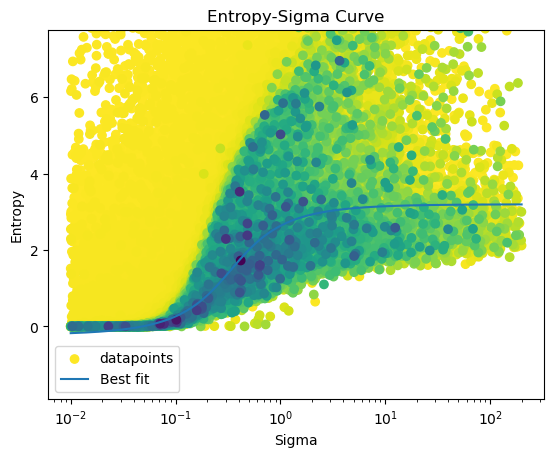

Step: 5600,  Loss: 1.2472918033599854
Step: 5601,  Loss: 1.5117061138153076
Step: 5602,  Loss: 1.1869819164276123
Step: 5603,  Loss: 1.3891735076904297
Step: 5604,  Loss: 1.3788716793060303
Step: 5605,  Loss: 1.2598023414611816
Step: 5606,  Loss: 1.3364075422286987
Step: 5607,  Loss: 1.1421865224838257
Step: 5608,  Loss: 1.2182385921478271
Step: 5609,  Loss: 1.5433882474899292
Step: 5610,  Loss: 1.3230229616165161
Step: 5611,  Loss: 1.0450528860092163
Step: 5612,  Loss: 1.6167144775390625
Step: 5613,  Loss: 1.090592384338379
Step: 5614,  Loss: 1.3051998615264893
Step: 5615,  Loss: 1.2851649522781372
Step: 5616,  Loss: 1.280340313911438
Step: 5617,  Loss: 1.4535109996795654
Step: 5618,  Loss: 1.6744141578674316
Step: 5619,  Loss: 1.4495954513549805
Step: 5620,  Loss: 1.223217248916626
Step: 5621,  Loss: 1.1203651428222656
Step: 5622,  Loss: 1.0381205081939697
Step: 5623,  Loss: 1.567014455795288
Step: 5624,  Loss: 1.1599713563919067
Step: 5625,  Loss: 1.0369608402252197
Step: 5626,  Los

KeyboardInterrupt: 

In [3]:
schedule_update_frequency=2000
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  # Define your optimizer
        tokens = batch['input_ids'].to(device)
        x,sigma=model.make_sample(tokens)
        prediction=model(x,sigma)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            schedule.update_optimal_parameters()

        if i%200==0 and i!=0:
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()


        print(f"Step: {i},  Loss: {loss.item()}")


In [ ]:
model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:01<00:00, 505.25it/s]


tensor([[[-5.0316e+05, -1.4606e+06,  2.2594e+04,  ..., -1.3636e+05,
          -1.0231e+06, -3.9502e+05],
         [ 6.2822e+05,  5.0553e+05,  1.2051e+06,  ..., -2.4368e+05,
          -1.3523e+05, -8.1681e+05],
         [-1.4182e+06, -9.9267e+05,  4.8397e+04,  ..., -9.1541e+05,
          -1.0770e+06,  9.3402e+04],
         ...,
         [-5.1716e+05,  3.6765e+02, -1.4177e+06,  ..., -1.1860e+06,
          -1.4212e+06, -1.5307e+06],
         [-4.6251e+05,  1.2260e+06, -8.9371e+05,  ..., -2.3114e+04,
           5.3626e+05, -7.4723e+05],
         [-1.8833e+06,  1.6788e+05, -1.4138e+06,  ...,  2.9020e+05,
          -8.7660e+05, -8.2758e+04]]], device='cuda:0')

In [4]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.1629,  0.2979,  5.1791, -1.9839])